# SPISEA: Making a Cluster with BD Candidates

This is a document to generate a synthetic cluster in SPISEA with the addition of brown dwarf candidates. It will follow the Quick Start Guide closely, but with changes due to a lower mass limit and ability to consider smaller objects.

In [1]:
# Import necessary packages. 
from spisea import synthetic, evolution, atmospheres, reddening, ifmr
from spisea.imf import imf, multiplicity
import numpy as np
import pylab as py
import pdb
import matplotlib.pyplot as plt
%matplotlib inline

### 1: Making an Isochrone Object for our Cluster

In [6]:
# Define isochrone parameters
logAge = np.log10(5*10**7.) # Age in log(years)
AKs = 0.8 # extinction in mags
dist = 4000 # distance in parsec
metallicity = 0 # Metallicity in [M/H]

# Define evolution/atmosphere models and extinction law
evo_model = evolution.MISTv1() 
atm_func = atmospheres.get_merged_atmosphere
red_law = reddening.RedLawHosek18b()

# Also specify filters for synthetic photometry (optional). Here we use 
# the HST WFC3-IR F127M, F139M, and F153M filters
filt_list = ['wfc3,ir,f127m', 'wfc3,ir,f139m', 'wfc3,ir,f153m']

# Specify the directory we want the output isochrone
# table saved in. If the directory does not already exist,
# SPISEA will create it.
iso_dir = 'isochrones/'

# Make IsochronePhot object. Note that this will take a minute or two, 
# unless the isochrone has been generated previously.
#
# Note that this is not show all of the user options 
# for IsochronePhot. See docs for complete list of options.
my_iso = synthetic.IsochronePhot(logAge, AKs, dist, metallicity=0,
                            evo_model=evo_model, atm_func=atm_func,
                            red_law=red_law, filters=filt_list,
                                iso_dir=iso_dir)

Isochrone generation took 57.656324 s.
Making photometry for isochrone: log(t) = 7.70  AKs = 0.80  dist = 4000
     Starting at:  2024-07-03 13:28:50.362836   Usually takes ~5 minutes
Starting filter: wfc3,ir,f127m   Elapsed time: 0.00 seconds
Starting synthetic photometry
M =   0.100 Msun  T =  3021 K  m_hst_f127m = 23.96
M =   1.336 Msun  T =  6744 K  m_hst_f127m = 18.16
M =   4.781 Msun  T = 15818 K  m_hst_f127m = 14.97
M =   6.899 Msun  T = 17664 K  m_hst_f127m = 13.11
M =   6.911 Msun  T =  6971 K  m_hst_f127m = 10.61
M =   6.988 Msun  T =  3957 K  m_hst_f127m = 9.32
M =   7.297 Msun  T =  3738 K  m_hst_f127m = 8.65
Starting filter: wfc3,ir,f139m   Elapsed time: 18.77 seconds
Starting synthetic photometry
M =   0.100 Msun  T =  3021 K  m_hst_f139m = 23.57
M =   1.336 Msun  T =  6744 K  m_hst_f139m = 17.69
M =   4.781 Msun  T = 15818 K  m_hst_f139m = 14.59
M =   6.899 Msun  T = 17664 K  m_hst_f139m = 12.74
M =   6.911 Msun  T =  6971 K  m_hst_f139m = 10.18
M =   6.988 Msun  T =  39

In [7]:
# The stars in the isochrone and associated properties  
# are stored in an astropy table called "points" 
# within the IsochronePhot object. 
print(my_iso.points)

          L                   Teff        ...    m_hst_f153m    
          W                    K          ...                   
---------------------- ------------------ ... ------------------
1.6794720325683452e+24 3020.5752857611837 ...  22.92776805171169
   1.7370492282378e+24  3026.596844621303 ...  22.89188358781423
1.8137828986723996e+24 3034.2260855891886 ... 22.845919008054395
1.8944919038459294e+24   3041.88871922475 ... 22.799687950466488
1.9794440999691394e+24  3049.612041774559 ... 22.753170128603966
2.0689567354242308e+24  3057.411643839487 ... 22.706329930464427
                   ...                ... ...                ...
 8.450906433033863e+30 3441.3110094585145 ...  6.433232663228037
 8.557948261819579e+30 3436.3422272496196 ...  6.420004996757628
 8.585406026317698e+30  3435.514440695956 ...  6.416813383458505
 8.699093176188767e+30 3430.8941764462447 ...  6.403203879003122
 8.881152106206099e+30  3423.152501093308 ...  6.381645353870332
 8.910673547171454e+30 34

In [8]:
# Example case:
# Identify a 1 M_sun star, print F127M, F139M, and F153M mags
idx = np.where( abs(my_iso.points['mass'] - 1.0) == min(abs(my_iso.points['mass'] - 1.0)) )[0]
f127m = np.round(my_iso.points[idx[0]]['m_hst_f127m'], decimals=3)
f139m = np.round(my_iso.points[idx[0]]['m_hst_f139m'], decimals=3)
f153m = np.round(my_iso.points[idx[0]]['m_hst_f153m'], decimals=3)
print('1 M_sun: F127M = {0} mag, F139M = {1} mag, F153M = {2} mag'.format(f127m, f139m, f153m))

1 M_sun: F127M = 19.299 mag, F139M = 18.792 mag, F153M = 18.265 mag


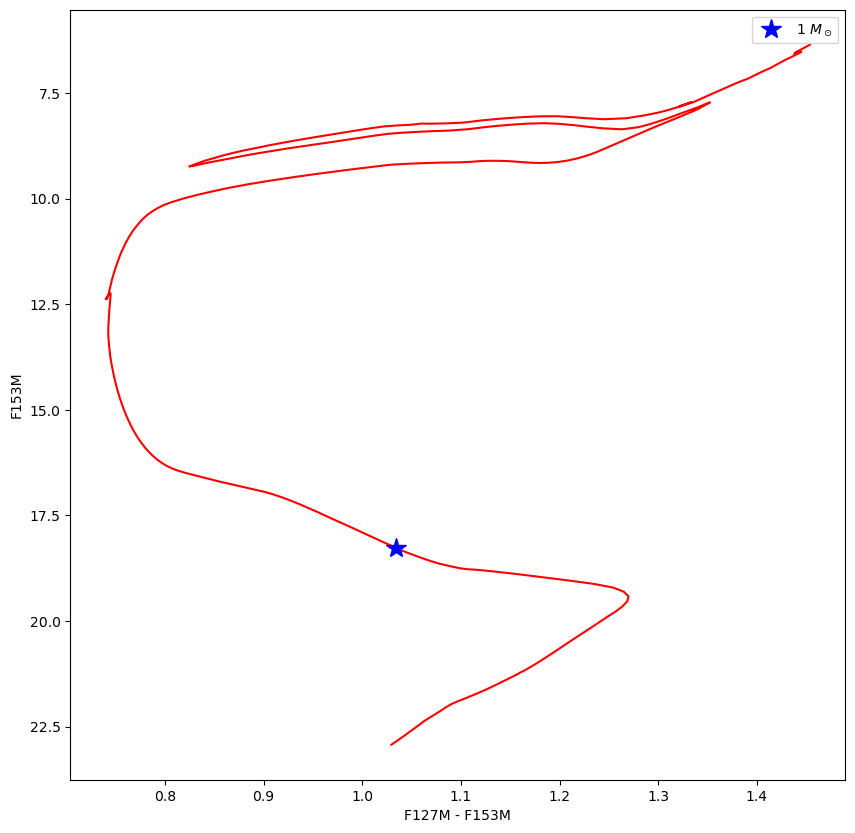

In [9]:
# Make a color-magnitude diagram from the isochrone
py.figure(1, figsize=(10,10))
py.clf()
py.plot(my_iso.points['m_hst_f127m'] - my_iso.points['m_hst_f153m'], 
       my_iso.points['m_hst_f153m'], 'r-', label='_nolegend_')
py.plot(my_iso.points['m_hst_f127m'][idx] - my_iso.points['m_hst_f153m'][idx], 
       my_iso.points['m_hst_f153m'][idx], 'b*', ms=15, label='1 $M_\odot$')
py.xlabel('F127M - F153M')
py.ylabel('F153M')
py.gca().invert_yaxis()
py.legend()

### 2: Bringing in an IMF

In [27]:
# Make multiplicity object Here, we use the MultiplicityUnresolved object, 
# based on Lu+13. This means that star systems will be unresolved, i.e., 
# that all components of a star system are combined into a single "star" in the cluster
imf_multi = multiplicity.MultiplicityUnresolved()

# Make IMF object; we'll use a broken power law with the parameters from Kroupa+01

# NOTE: when defining the power law slope for each segment of the IMF, we define
# the entire exponent, including the negative sign. For example, if dN/dm $\propto$ m^-alpha,
# then you would use the value "-2.3" to specify an IMF with alpha = 2.3. 

my_imf = imf.Muzic_2017(multiplicity=imf_multi)

### 3: Generating Cluster

In [28]:
# Define total cluster mass
mass = 10**5.

# Make cluster object
cluster = synthetic.ResolvedCluster(my_iso, my_imf, mass)

Found 177 stars out of mass range
Found 47 companions out of stellar mass range


In [29]:
# Look at star systems table
print(cluster.star_systems)

        mass        isMultiple ...    m_hst_f153m     N_companions
------------------- ---------- ... ------------------ ------------
0.35277838228082964       True ... 21.056406061698077            2
 0.4109143920284334      False ...  20.80304487623113            0
0.44680797582475024      False ...  20.65082717236568            0
0.16814683886383167      False ...  22.19558068545299            0
 0.1998139027268053      False ... 21.941926401844015            0
 0.4740288564083312      False ... 20.534885068309187            0
 1.0126972980825961       True ... 17.971915603237292            2
                ...        ... ...                ...          ...
 5.3779990877122295       True ... 13.776442294620189            1
 0.6634904439575919      False ... 19.510526216999857            0
   1.35508336893066       True ...  17.17251870764391            1
 3.7213803186176304      False ... 14.933652308856155            0
 1.5278429001189309      False ...  16.86599227492448         

In [30]:
# The companions table is accessed in a similar way
print(cluster.companions)

system_idx         mass        ...    m_hst_f139m        m_hst_f153m    
---------- ------------------- ... ------------------ ------------------
         0 0.09565348913151368 ...                nan                nan
         0 0.03322585947572763 ...                nan                nan
         6 0.08726287084485738 ...                nan                nan
         6  0.6433751483393655 ...  20.33081658819904 19.657228868526335
         7 0.06161747316330432 ...                nan                nan
        13  1.7263481600403079 ... 17.018762642329463  16.60938637243561
        14  0.2737246431039749 ... 22.090906238571662   21.4548720525631
       ...                 ... ...                ...                ...
       396 0.03899827614913988 ...                nan                nan
       398 0.26985155635770386 ... 22.112746284229008 21.476822094207677
       400  2.0771742779244846 ...   16.6610738152462  16.27195342256348
       400  1.8654858596867614 ... 16.8700423604419

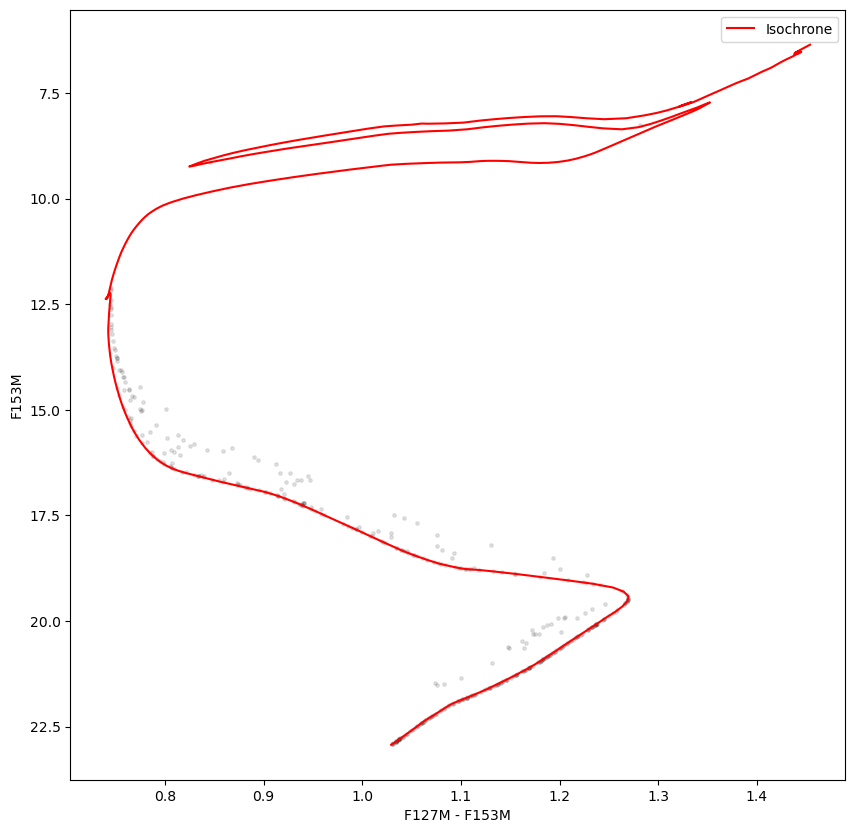

In [31]:
# Look at the cluster CMD, compared to input isochrone. Note the impact of
# multiple systems on the photometry
clust = cluster.star_systems
iso = my_iso.points

py.figure(2, figsize=(10,10))
py.clf()
py.plot(clust['m_hst_f127m'] - clust['m_hst_f153m'], clust['m_hst_f153m'],
       'k.', ms=5, alpha=0.1, label='__nolegend__')
py.plot(iso['m_hst_f127m'] - iso['m_hst_f153m'], iso['m_hst_f153m'],
       'r-', label='Isochrone')
py.xlabel('F127M - F153M')
py.ylabel('F153M')
py.gca().invert_yaxis()
py.legend()